In [5]:
import os
import sys
from pathlib import Path
from typing import Optional, Any, List, Tuple, Dict, Union

import cv2
import hashlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torch
from torch import Tensor
import torch.nn as nn
from torchvision import utils as vutils
from torchvision import transforms
from IPython.display import display
from ipywidgets import interactive, IntSlider, HBox, VBox

sys.path.append('../src')
import models_mae
from dataset import LOCODataModule, ImageNetTransforms
from models_mae import MaskedAutoencoderViT
from method import MAEMethod
from params import MAEParams
from common import ImageLogCallback, prepare_model, to_rgb_from_tensor, get_patches_containing_bbox_1D, get_patches_containing_mask
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

ModuleNotFoundError: No module named 'segment_anything'

In [4]:
!pip install h5py

  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/a7/d9/ac660616671e30d70c091e46ed4fdc50df48ca79b1ac99df5499a45de128/h5py-3.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.0 MB/s eta 0:00:00a 0:00:01


In [2]:
params = MAEParams()
ckpt_file = "/home/dl/takamagahara/hutodama/MAE/src/wandb/run-20230807_101801-kuia1oij/ckpt/last.ckpt"
img_transforms = ImageNetTransforms(input_resolution=params.resolution)
datamodule = LOCODataModule(
    data_root=params.data_root,
    category=params.category,
    input_resolution=params.resolution,
    img_transforms=img_transforms,
    batch_size=params.batch_size,
    num_workers=params.num_workers,
)

mae = getattr(models_mae, params.arch)()
model_ckpt_path = "/home/dl/takamagahara/hutodama/MAE/segment-anything/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=model_ckpt_path)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=30,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.90,
    box_nms_thresh=0.30,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

method = MAEMethod(
    mae=mae,
    datamodule=datamodule,
    params=params,
    # mask_generator= mask_generator,
)

method.load_state_dict(torch.load(ckpt_file)['state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

method.eval()
method.to(device)

MAEMethod(
  (model): MaskedAutoencoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2)

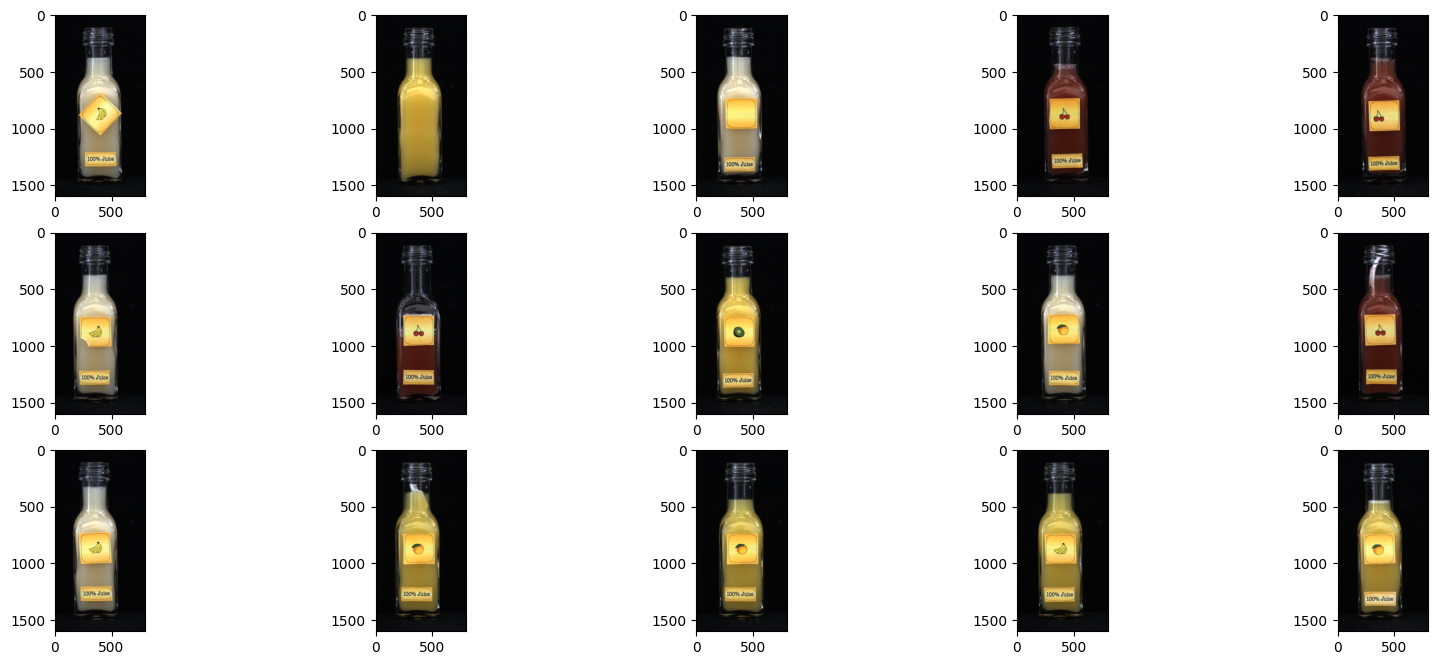

In [3]:
# load dataset
datamodule.setup(stage='test')
train_dataset = datamodule.train_dataset
test_dataset = datamodule.test_dataset
valid_dataset = datamodule.valid_dataset
train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()
valid_dataloader = datamodule.val_dataloader()

train_files = datamodule.train_dataset.files
test_files = datamodule.test_dataset.files

labels = test_dataloader.dataset.labels
abnormal_indices = [idx for idx, label in enumerate(labels) if label == 1]
normal_indices = [idx for idx, label in enumerate(labels) if label == 0]

# indices of the logical anomalies and structural anomalies
log_indices = [idx for idx, file in enumerate(test_dataloader.dataset.files) if 'logical' in str(file)]
str_indices = [idx for idx, file in enumerate(test_dataloader.dataset.files) if 'structural' in str(file)]

# sample anomal images
num_samples = 5 * 3
perm = torch.randperm(len(abnormal_indices))[:num_samples]
indices = [abnormal_indices[idx] for idx in perm]
sample_files = [test_files[idx] for idx in indices]

fig, axes = plt.subplots(num_samples // 5, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    img = Image.open(sample_files[i])
    ax.imshow(img)

In [4]:
# util functions

def inference(model: MaskedAutoencoderViT, inputs: Tensor, params: Any):
    """Inference function.

    Args:
        model (MaskedAutoencoderViT): model
        inputs (Tensor): inputs batch (B, C, H, W)
        params (Any): params
    """
    if params.gpus > 0:
        batch = inputs.to(device)
    loss, pred, mask = model(inputs)
    return loss, pred, mask

def get_batched_inputs(dataset, indices: List):
    inputs = [dataset[idx] for idx in indices]
    img_batch = [input_["images"] for input_ in inputs]
    file_batch = [input_["files"] for input_ in inputs]
    label_batch = [input_["labels"] for input_ in inputs]

    img_batch = torch.stack(img_batch, dim=0)
    
    output = {"images": img_batch, "files": file_batch, "labels": label_batch}
    return output


def make_grid_results(method, inputs: Tensor, params: Any, mask_ratio: float = 0.75, \
    mask_indices = None):
    """reformat results to a grid."""
    img_batch = inputs["images"].to(device)
    _, pred, mask = method.inference(inputs, mask_ratio=mask_ratio, mask_indices=mask_indices)  # pred: (B, L, p*p*3), mask: (B, L)
    
    patch_size = method.model.patch_embed.patch_size[0]
    mask = mask.detach()  # -> (B, L)
    print(mask.shape)
    mask = mask.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # -> (B, L, p*p*3)
    mask = method.model.unpatchify(mask)  # -> (B, 3, H, W)
    
    pred = method.model.unpatchify(pred)  # -> (B, 3, H, W)
    
    # mask input images.
    im_masked = img_batch * (1 - mask) # -> (B, 3, H, W)
    im_paste = im_masked + pred * mask # -> (B, 3, H, W)
    
    # convert tensor to rgb format.
    images = to_rgb_from_tensor(img_batch.cpu()) # -> (B, 3, H, W)
    im_masked = to_rgb_from_tensor(im_masked.cpu())  # -> (B, 3, H, W)
    im_paste = to_rgb_from_tensor(im_paste.cpu())  # -> (B, 3, H, W)
    
    # combine images in a way so we can display all outputs in one grid.
    out = torch.cat([images.unsqueeze(1), im_masked.unsqueeze(1), im_paste.unsqueeze(1)], dim=1)  # -> (B, 3, 3, H, W)
    out = out.view(-1, *out.shape[2:])  # -> (3*B, 3, H, W)
    
    images = vutils.make_grid(
            out.cpu(),
            nrows=out.shape[0] // 3,
            ncols=3,
            normalize=False, 
    )
    # images: (3, H, W)
    return images

def show_output_image(method, inputs: Tensor, params: Any, \
    img_idx, mask_ratio: float = 0.75, mask_indices = None):
    img_batch = inputs["images"].to(device)
    _, pred, mask = method.inference(inputs, mask_ratio=mask_ratio)  # pred: (B, L, p*p*3), mask: (B, L)
    
    patch_size = method.model.patch_embed.patch_size[0]
    mask = mask.detach()  # -> (B, L)
    mask = mask.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # -> (B, L, p*p*3)
    mask = method.model.unpatchify(mask)  # -> (B, 3, H, W)
    
    pred = method.model.unpatchify(pred).detach()  # -> (B, 3, H, W)
    
    # mask input images.
    im_masked = img_batch * (1 - mask) # -> (B, 3, H, W)
    im_paste = im_masked + pred * mask # -> (B, 3, H, W)
    
    # convert tensor to rgb format.
    images = to_rgb_from_tensor(img_batch.cpu()) # -> (B, 3, H, W)
    im_masked = to_rgb_from_tensor(im_masked.cpu())  # -> (B, 3, H, W)
    im_paste = to_rgb_from_tensor(im_paste.cpu())  # -> (B, 3, H, W)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[img_idx].permute(1, 2, 0))
    ax[1].imshow(im_masked[img_idx].permute(1, 2, 0))
    ax[2].imshow(im_paste[img_idx].permute(1, 2, 0))
    
    ax[0].set_title("Input")
    ax[1].set_title("Masked")
    ax[2].set_title("Output")

torch.Size([15, 196])


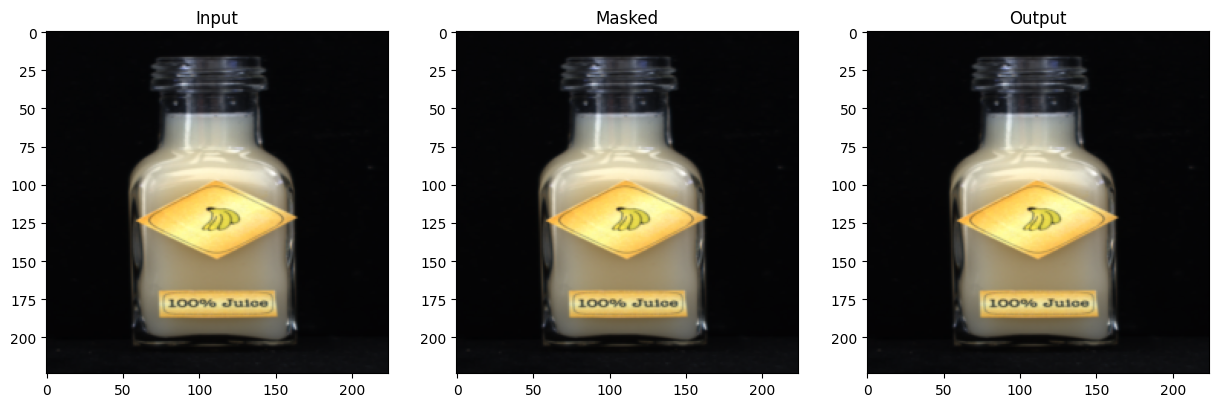

In [5]:
inputs = get_batched_inputs(test_dataset, indices)
grid_images = make_grid_results(method, inputs, params, 0.75)
show_output_image(method, inputs, params, 0)

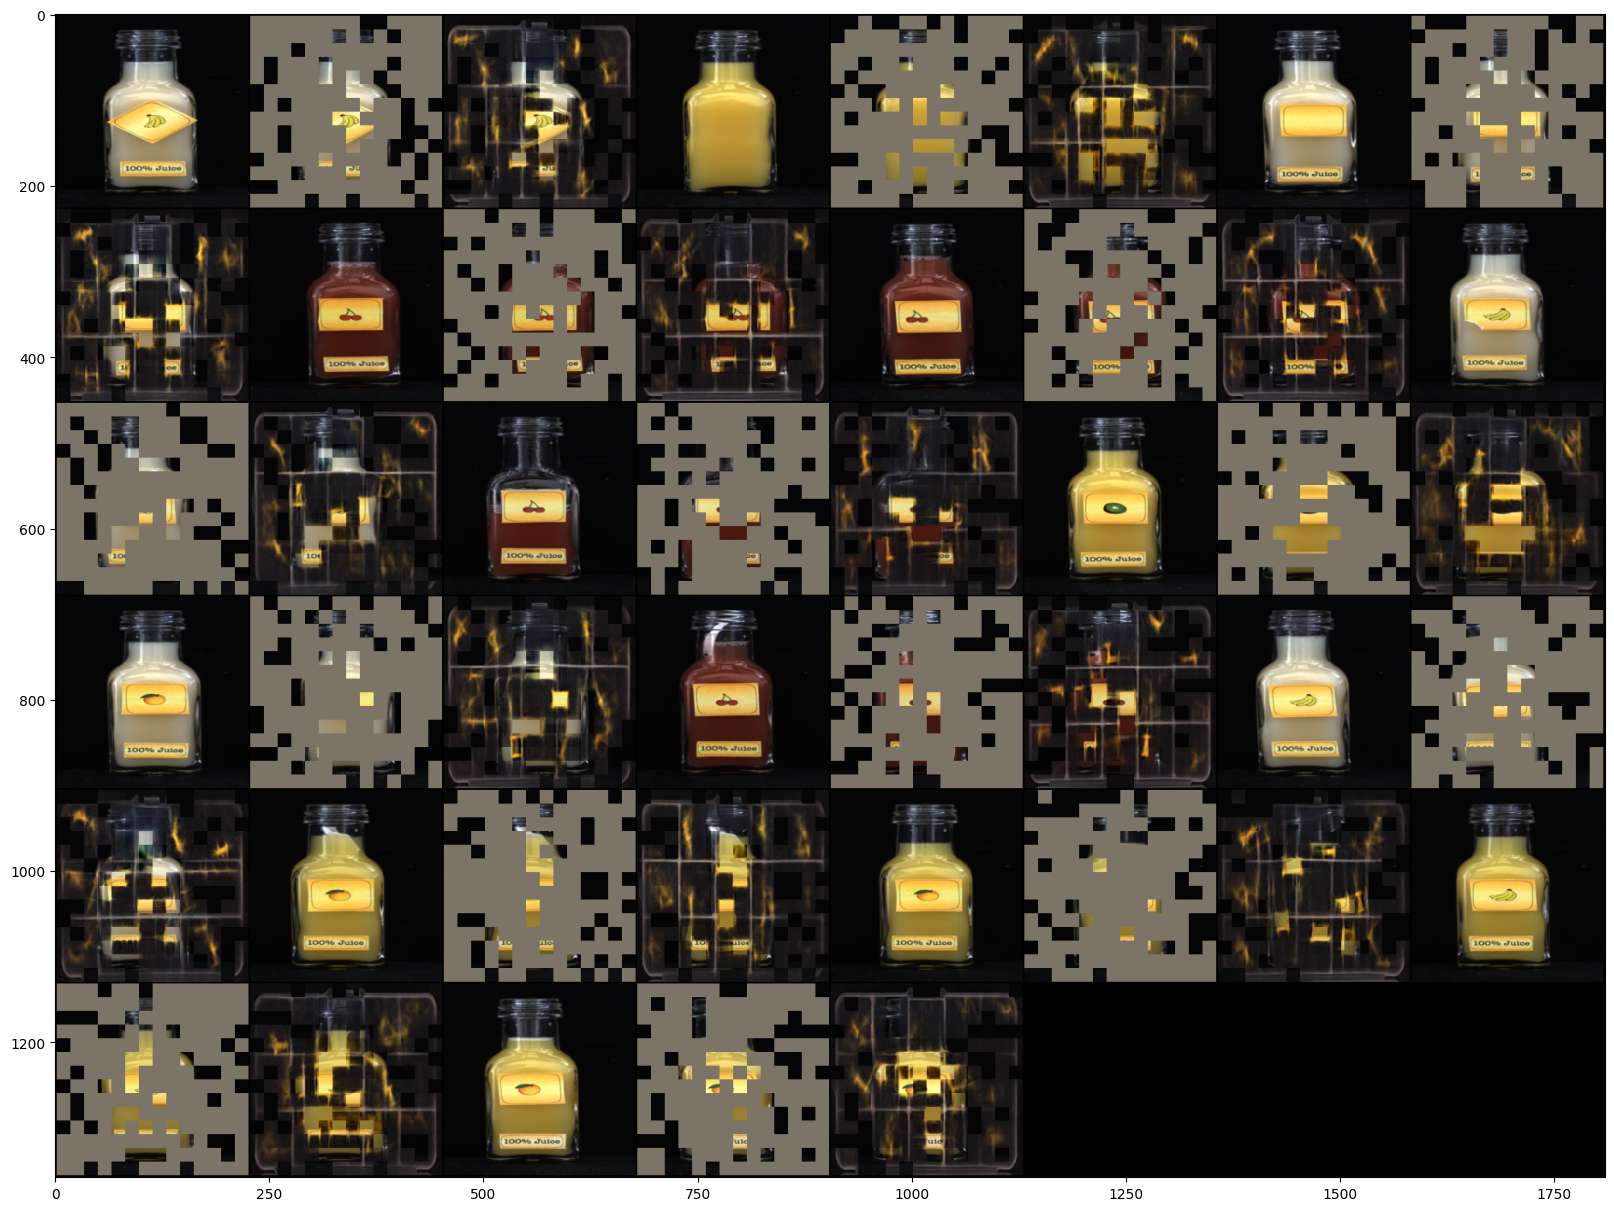

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(grid_images.permute(1, 2, 0))

In [7]:
patch_size = (16, 16)
img_size = (224, 224)

# Display the image with initial bbox
img_batch = inputs["images"]
img_batch = to_rgb_from_tensor(img_batch)
img_idx = 0
img = img_batch[img_idx].permute(1, 2, 0).numpy()


def display_bbox(x, y, width, height):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(img)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

# Create sliders for bbox coordinates and size
x_slider = IntSlider(min=0, max=img.shape[1], step=1, value=0, description='x')
y_slider = IntSlider(min=0, max=img.shape[0], step=1, value=0, description='y')
width_slider = IntSlider(min=0, max=img.shape[1], step=1, value=50, description='width')
height_slider = IntSlider(min=0, max=img.shape[0], step=1, value=50, description='height')

# Combine the sliders with the display function
interactive_plot = interactive(display_bbox, x=x_slider, y=y_slider, width=width_slider, height=height_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='x', max=224), IntSlider(value=0, description='y', max=22…

torch.Size([15, 196])


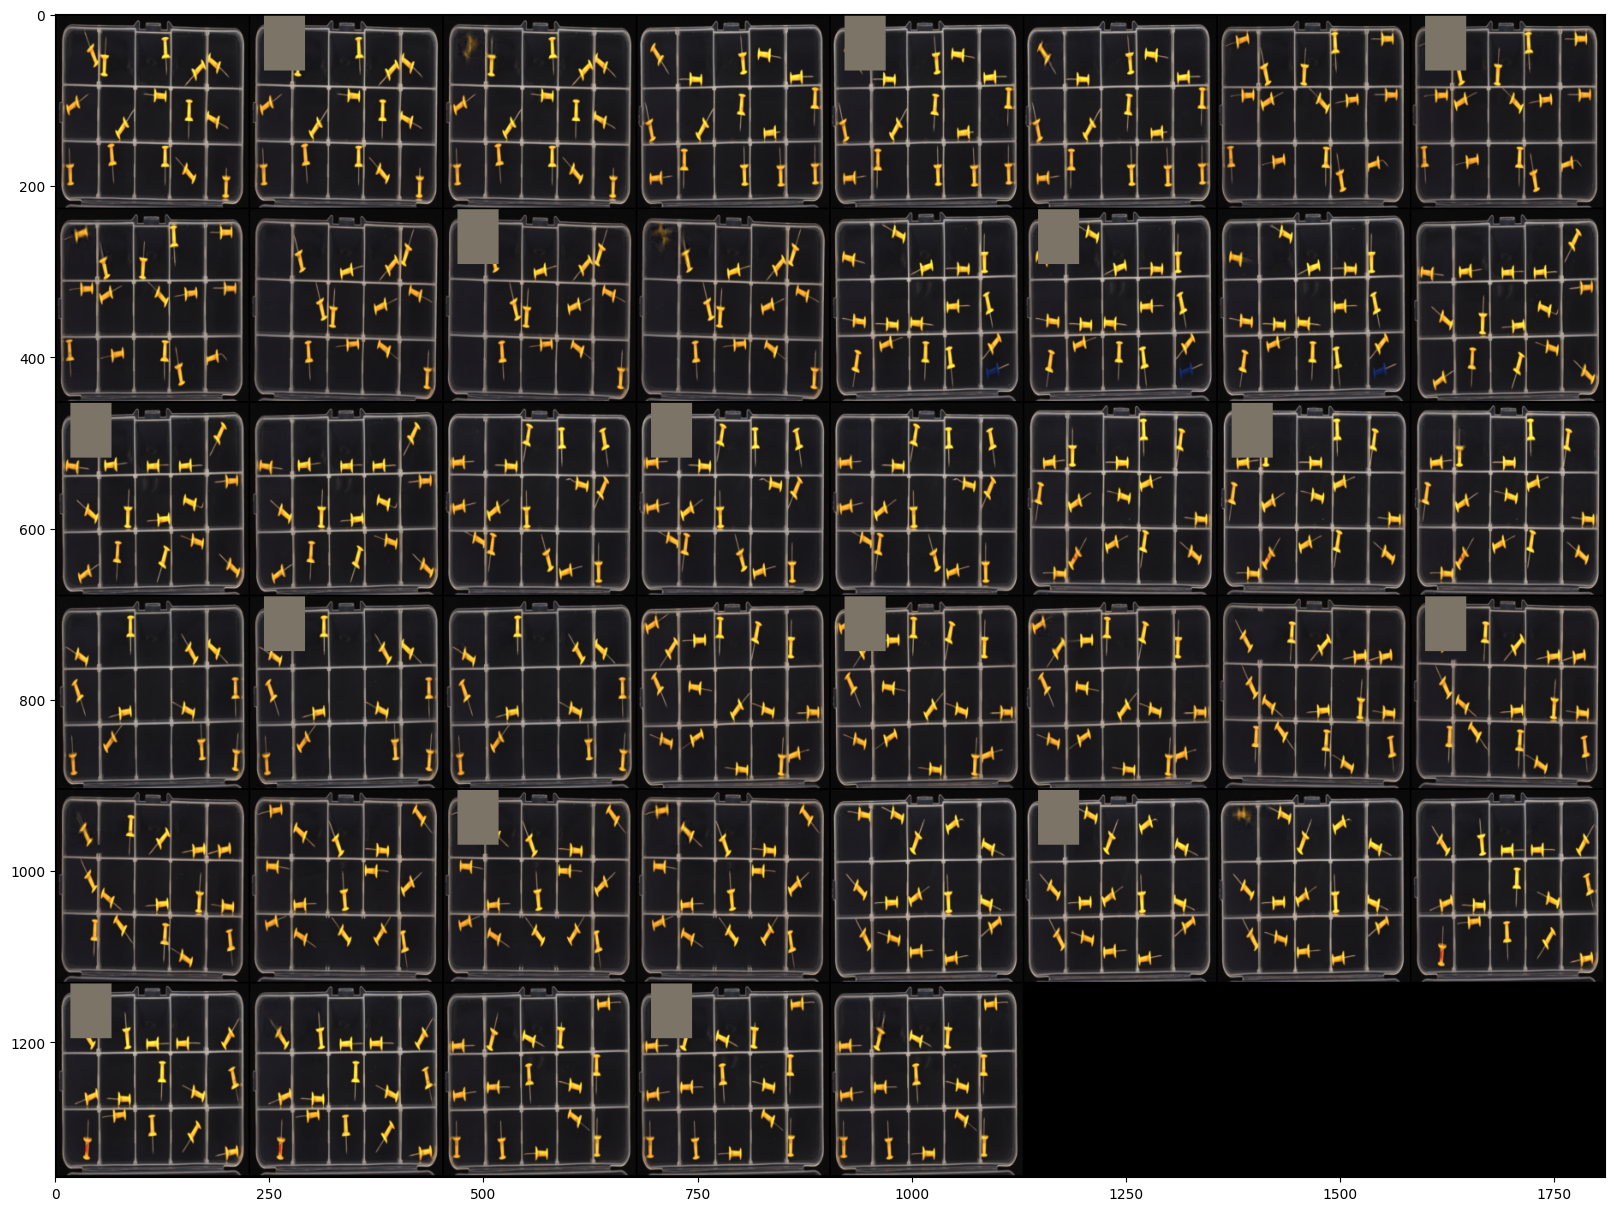

In [10]:
def xyxy2xywh(x):
    y = x.clone()
    y[0] = x[0] + x[2] / 2
    y[1] = x[1] + x[3] / 2
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y

def xywh2xyxy(x):
    y = x.clone()
    y[0] = x[0]
    y[1] = x[1]
    y[2] = x[0] + x[2]
    y[3] = x[1] + x[3]
    return y

bbox_xyxy = xywh2xyxy(torch.tensor([29, 11, 23, 48]))
    
mask_indices = get_patches_containing_bbox_1D(bbox_xyxy, patch_size, img_size)
grid_images = make_grid_results(method, inputs, params, 0.75, mask_indices=mask_indices)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(grid_images.permute(1, 2, 0))

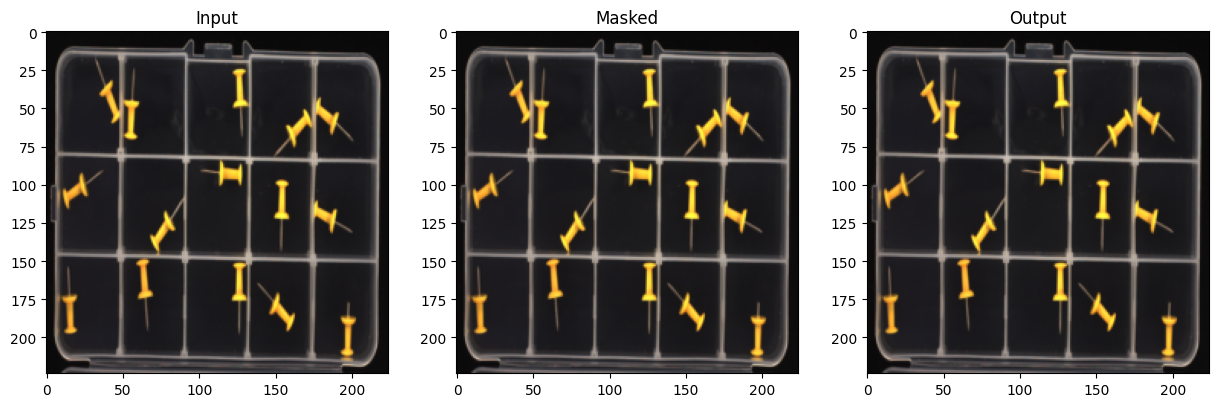

In [9]:
show_output_image(method, inputs, params, img_idx, mask_indices=mask_indices)

### SAM

In [12]:

# sam utils
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def select_topk_masks(mask_list: list, top_k: int):
    """Select top k masks from mask_list based on the mask area.
    Args:
        mask_list (List[dict]): list of masks, each mask is a dict with keys: 'mask', 'area'
        top_k (int): number of top masks to select
    Returns:
        List[dict]: list of selected masks
    """
    assert top_k <= len(mask_list), "top_k should be less than the number of masks"
    assert mask_list[0].get('area') is not None, "mask_list should contain 'area' key"
    
    areas = [mask['area'] for mask in mask_list]
    sort_indices = np.argsort(areas)[::-1]  # descending order
    topk_indices = sort_indices[:top_k]
    
    masks = [mask_list[i] for i in topk_indices]
    return masks

def select_masks_by_area(mask_list, thresh_range: list):
    """Remove bigger masks from the list of masks.
    Args:
        mask_list (list): list of masks (np.ndarray)
        thresh_range (list): valid area range of masks, e.g. [0, 1000]
    """
    return [mask for mask in mask_list if mask["area"] < thresh_range[1] and mask["area"] > thresh_range[0]]

In [13]:
image = img_batch.permute(0, 2, 3, 1).cpu().numpy()[0]
image = (image * 255).astype(np.uint8)

model_ckpt_path = "/home/dl/takamagahara/hutodama/MAE/segment-anything/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=model_ckpt_path)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=30,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.90,
    box_nms_thresh=0.30,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)
masks = mask_generator.generate(image)

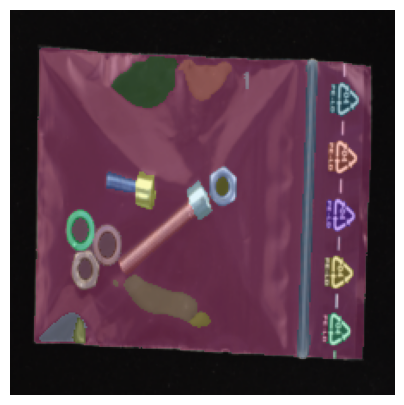

In [14]:
top_k = 15
masks = select_masks_by_area(masks, [0, 1000000])
selected_masks = select_topk_masks(masks, top_k)

plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

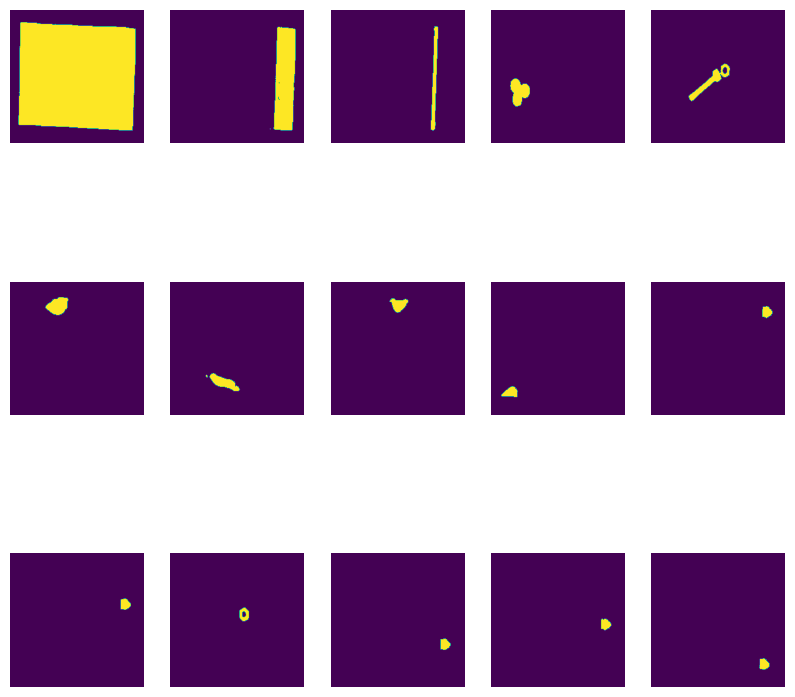

In [15]:
# plot each mask.
fig, ax = plt.subplots(top_k//5, 5, figsize=(10, 10))

for i in range(top_k//5):
    for j in range(5):
        ax[i, j].imshow(selected_masks[i * 5 + j]["segmentation"])
        ax[i, j].axis('off')

In [16]:
token_idx, patch_masks = get_patches_containing_mask(selected_masks[4]["segmentation"], patch_size, img_size)
token_idx = list(np.where(patch_masks)[0])

torch.Size([15, 196])


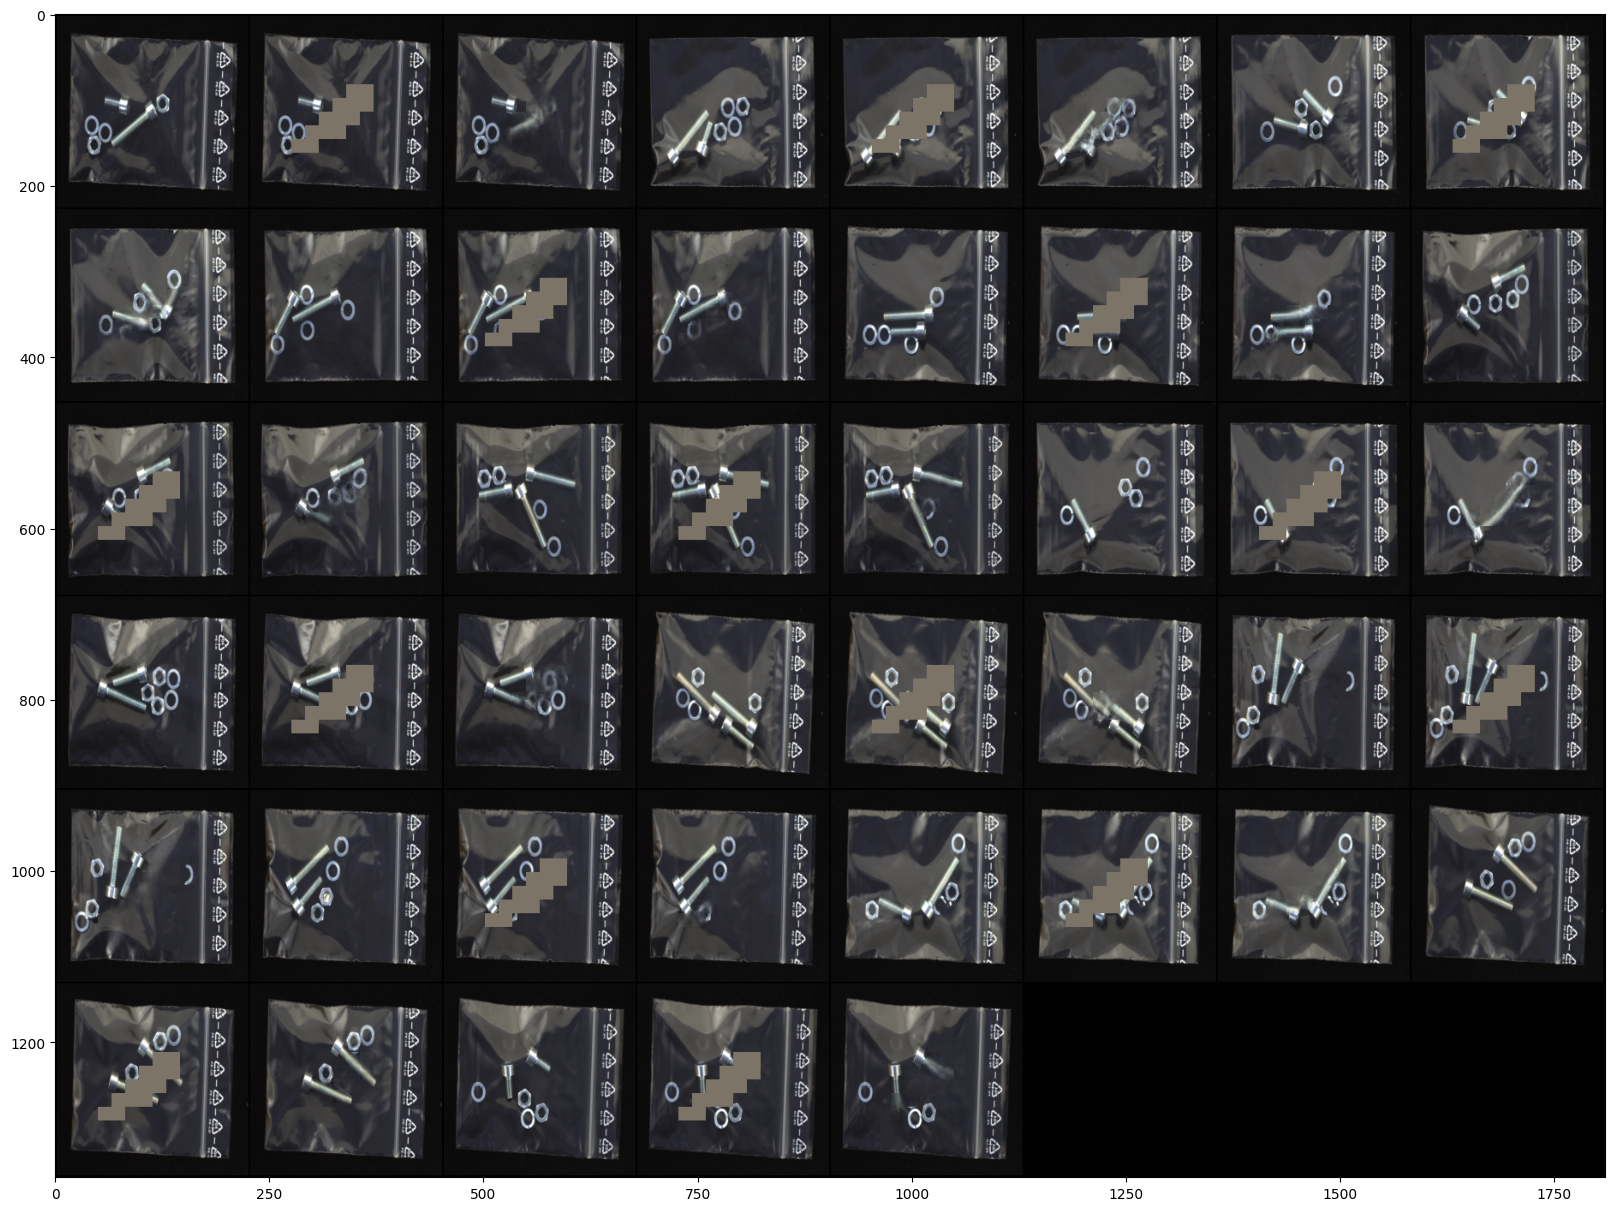

In [17]:
grid_images = make_grid_results(method, inputs, params, 0.75, mask_indices=token_idx)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(grid_images.permute(1, 2, 0))

In [18]:
def tensor2hash(tensor):
    byte_data = tensor.cpu().numpy().tobytes()
    return hashlib.md5(byte_data).hexdigest()

tensor = torch.randn(3, 224, 224)
hash_value = tensor2hash(tensor)

def apply_to_batch(batch: Tensor, func):
    """Apply a function to a batch.
    Args:
        batch: (B, ...)
        func: a function that takes a tensor and returns a tensor.
    Returns:
        (B, ...)
    """
    batch_size = batch.shape[0]
    results = [func(item) for item in batch]
    return results

batch = torch.randn(4, 3, 224, 224)
hash_values = apply_to_batch(batch, tensor2hash)

print(hash_values)

['48fb93df2b78c1ed9f91c2e85f38999b', '3ca7308005de8861e77c3f8315e87db2', 'c5996295479bd714ffda054ad43027e5', '26e4de464740889b75359f06bafe8a82']


In [61]:
type(hash_value)

str